In [1]:
from fastkan import FastKAN as KAN 
import pandas as pd  
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
import random
from scipy.stats import poisson
# Display the noisy images
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

In [2]:
# Checking for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class AddGaussianNoise:
    def __init__(self, mean=0, var=0.00055):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        sigma = self.var ** 0.5
        gaussian = np.random.normal(self.mean, sigma, image.shape)
        noisy_image = np.clip(image + gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSpeckleNoise:
    def __init__(self, mean=0, var=0.0035):
        self.mean = mean
        self.var = var

    def __call__(self, image):
        gaussian = np.random.normal(self.mean, self.var ** 0.5, image.shape)
        noisy_image = np.clip(image + image * gaussian, 0, 1)
        return torch.tensor(noisy_image).float()

class AddSaltAndPepperNoise:
    def __init__(self, salt_prob=0.00899, pepper_prob=0.00899):
        self.salt_prob = salt_prob
        self.pepper_prob = pepper_prob

    def __call__(self, image):
        noisy_image = image
        salt_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.salt_prob, self.salt_prob])
        pepper_mask = np.random.choice([0, 1], size=image.shape, p=[1 - self.pepper_prob, self.pepper_prob])
        noisy_image[salt_mask == 1] = 1
        noisy_image[pepper_mask == 1] = 0
        return torch.tensor(noisy_image).float()

class AddPoissonNoise:
    def __init__(self, scale_factor=642, clip_min=0, clip_max=1):
        self.scale_factor = scale_factor
        self.clip_min = clip_min
        self.clip_max = clip_max

    def __call__(self, image):
        if self.scale_factor is None:
            vals = len(np.unique(image))
            scale_factor = 2 ** np.ceil(np.log2(vals))
        else:
            scale_factor = self.scale_factor

        noisy_image = np.random.poisson(image * scale_factor) / float(scale_factor)
        noisy_image = np.clip(noisy_image, self.clip_min, self.clip_max)
        return torch.tensor(noisy_image).float()

class AddOcclusionNoise:
    def __init__(self, size=0.80969):
        self.size = size

    def __call__(self, image):
        noisy_image = image
        h, w, _ = image.shape
        occlusion_size = int(min(h, w) * self.size)
        x = random.randint(0, w - occlusion_size)
        y = random.randint(0, h - occlusion_size)
        noisy_image[y:y+occlusion_size, x:x+occlusion_size] = 0
        return torch.tensor(noisy_image).float()

In [4]:
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    #AddOcclusionNoise(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    #AddGaussianNoise(),
    #AddSpeckleNoise(),
    #AddSaltAndPepperNoise(),
    #AddPoissonNoise(),
    #AddOcclusionNoise(),
])

# Load the dataset
trainset = torchvision.datasets.CIFAR10(
    root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\data", train=True, download=False, transform=transform
)
valset = torchvision.datasets.CIFAR10(
    root="C:\\Users\\Moneeb Raza\\Downloads\\KAN\\KAN-master\\data", train=False, download=False, transform=transform_test
)
train_loader = DataLoader(trainset, batch_size=64, shuffle=False)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

In [5]:
# Get a batch of images
#dataiter = iter(train_loader)
#images, labels = next(dataiter)
#copyImages = images.clone()

In [6]:
#noisy_images_gaussian = torch.stack([AddOcclusionNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2)

C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()


In [7]:
#copyImages.shape

torch.Size([64, 3, 32, 32])

Mean PSNR: 7.922628568597501


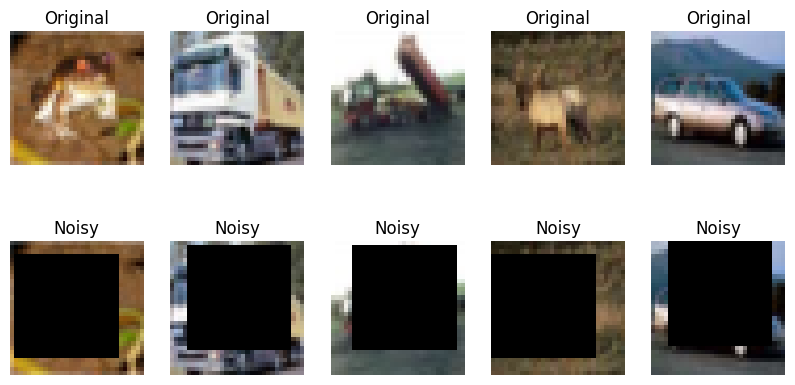

Mean SSIM: 0.2493392676115036


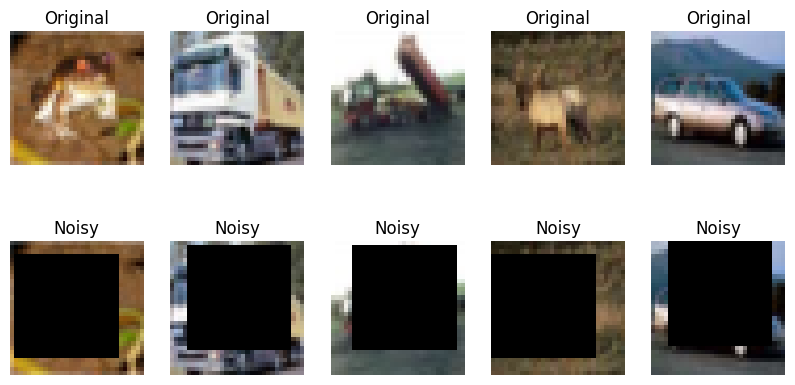

In [8]:
def calculate_psnr_batch(original, noisy,device= 'cuda'):
    original = original.to(device)
    noisy = noisy.to(device)
    batch_size = original.shape[0]
    psnr_values = []
    for i in range(batch_size):
        mse = torch.mean((original[i] - noisy[i]) ** 2).item()
        if mse == 0:
            psnr_values.append(100)
        else:
            max_pixel = 1.0
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    return np.mean(psnr_values)

def calculate_ssim_batch(original, noisy):
    batch_size = original.shape[0]
    ssim_values = []
    for i in range(batch_size):
        ssim_value = ssim(
            original[i].permute(1, 2, 0).numpy(),
            noisy[i].permute(1, 2, 0).numpy(),
            win_size=3,
            channel_axis=2,
            data_range=1.0
        )
        ssim_values.append(ssim_value)
    return np.mean(ssim_values)

# Calculate PSNR and SSIM for the test set
psnr_values = calculate_psnr_batch(copyImages[:5], noisy_images_gaussian[:5])
mean_psnr = np.mean(psnr_values)
print(f'Mean PSNR: {mean_psnr}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

ssim_values = calculate_ssim_batch(copyImages[:5], noisy_images_gaussian[:5])


mean_ssim = np.mean(ssim_values)


print(f'Mean SSIM: {mean_ssim}')

n = 5
plt.figure(figsize=(10, 5))
for i in range(n):
    plt.subplot(2, n, i+1)
    plt.imshow(np.transpose(copyImages[i], (1, 2, 0)))
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2, n, i+n+1)
    plt.imshow(np.transpose(noisy_images_gaussian[i], (1, 2, 0)))
    plt.title("Noisy")
    plt.axis('off')
plt.show()

Original Images


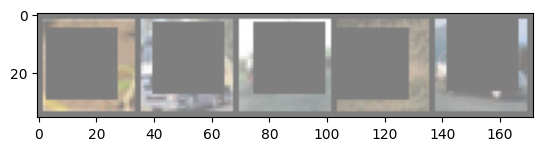

Images with Gaussian Noise


C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\38313

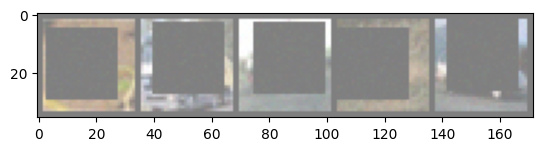

Images with Speckle Noise


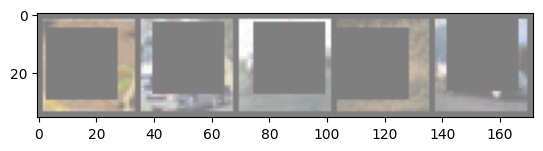

Images with Salt and Pepper Noise
Images with Poisson Noise


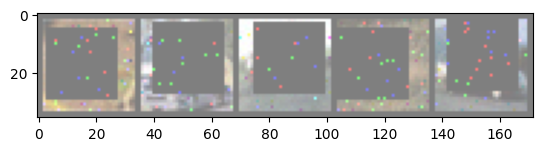

Images with Occlusion Noise


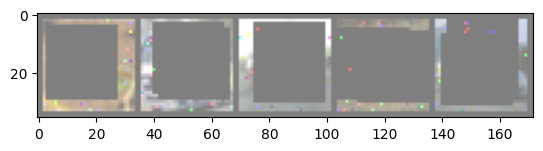

In [9]:
# Function to display images
def imshow(img, title=None):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.show()



# Display original images
print('Original Images')
imshow(torchvision.utils.make_grid(images[:5]))

# Add different types of noise to the images
noisy_images_gaussian = torch.stack([AddGaussianNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_speckle = torch.stack([AddSpeckleNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_salt_and_pepper = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_poisson = torch.stack([AddPoissonNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_occlusion = torch.stack([AddOcclusionNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)

# Display images with Gaussian noise
print('Images with Gaussian Noise')
imshow(torchvision.utils.make_grid(noisy_images_gaussian))

# Display images with Speckle noise
print('Images with Speckle Noise')
imshow(torchvision.utils.make_grid(noisy_images_speckle))

# Display images with Salt and Pepper noise
print('Images with Salt and Pepper Noise')
#imshow(torchvision.utils.make_grid(noisy_images_salt_and_pepper))

# Display images with Poisson noise
print('Images with Poisson Noise')
imshow(torchvision.utils.make_grid(noisy_images_poisson))

# Display images with Occlusion noise
print('Images with Occlusion Noise')
imshow(torchvision.utils.make_grid(noisy_images_occlusion))

Images with Gaussian Noise


C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()
C:\Users\Moneeb Raza\AppData\Local\Temp\ipykernel_20488\3831367308.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_image).float()


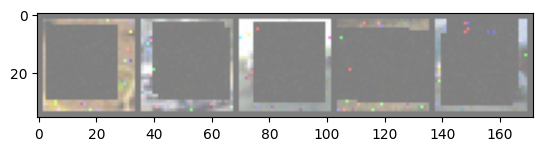

Images with Speckle Noise


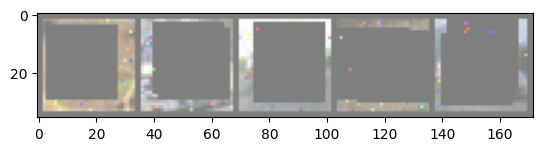

Images with Salt and Pepper Noise
Images with Poisson Noise


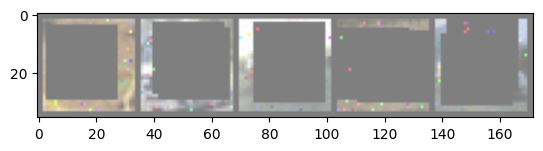

Images with Occlusion Noise


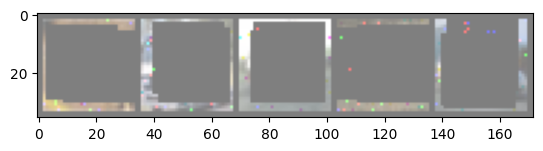

In [10]:
# Add different types of noise to the images
noisy_images_gaussian = torch.stack([AddGaussianNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_speckle = torch.stack([AddSpeckleNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
#noisy_images_salt_and_pepper = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_poisson = torch.stack([AddPoissonNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)
noisy_images_occlusion = torch.stack([AddOcclusionNoise()(img.permute(1, 2, 0)) for img in images[:5]]).permute(0, 3, 1, 2)

# Display images with Gaussian noise
print('Images with Gaussian Noise')
imshow(torchvision.utils.make_grid(noisy_images_gaussian))

# Display images with Speckle noise
print('Images with Speckle Noise')
imshow(torchvision.utils.make_grid(noisy_images_speckle))

# Display images with Salt and Pepper noise
print('Images with Salt and Pepper Noise')
#imshow(torchvision.utils.make_grid(noisy_images_salt_and_pepper))

# Display images with Poisson noise
print('Images with Poisson Noise')
imshow(torchvision.utils.make_grid(noisy_images_poisson))

# Display images with Occlusion noise
print('Images with Occlusion Noise')
imshow(torchvision.utils.make_grid(noisy_images_occlusion))

NameError: name 'image' is not defined

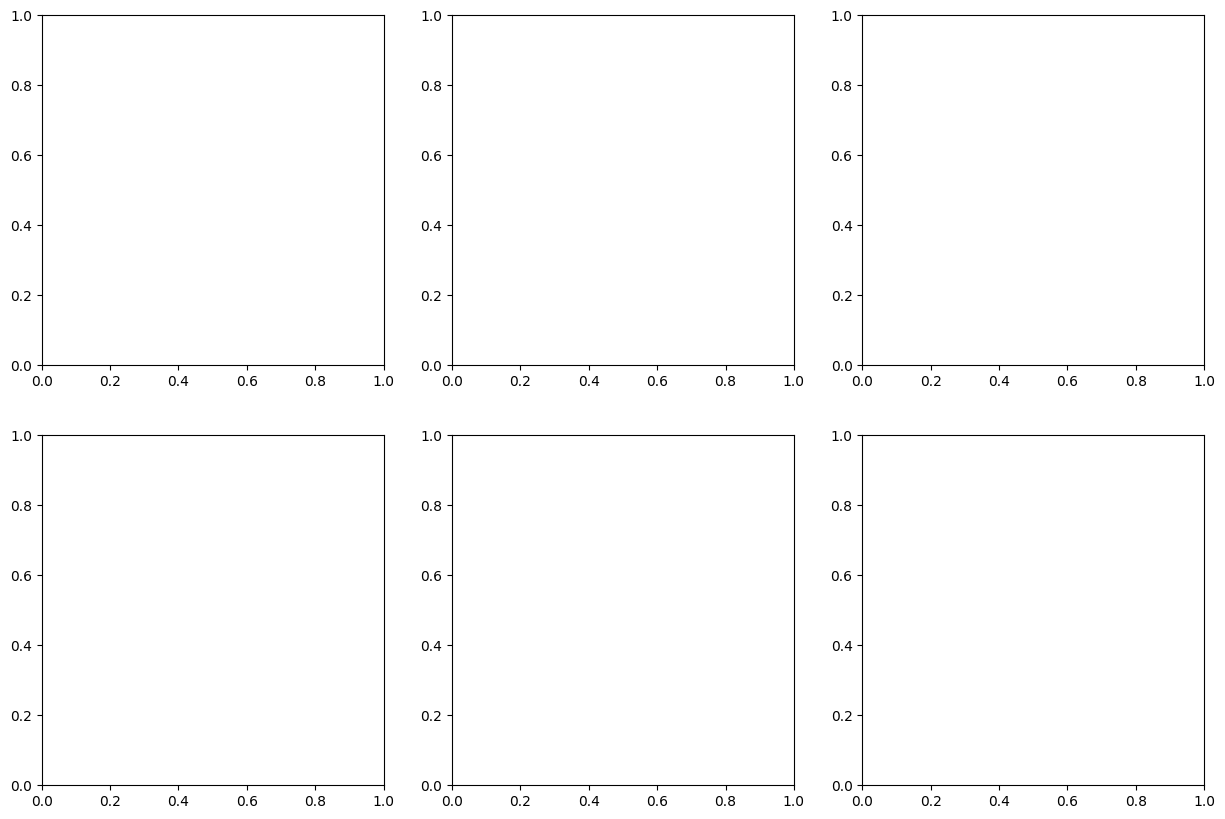

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(image)
axs[0, 0].set_title('Original Image')
axs[0, 1].imshow(gaussian_noisy_image)
axs[0, 1].set_title('Gaussian Noise')
axs[0, 2].imshow(speckle_noisy_image)
axs[0, 2].set_title('Speckle Noise')
axs[1, 0].imshow(salt_and_pepper_noisy_image)
axs[1, 0].set_title('Salt & Pepper Noise')
#axs[1, 1].imshow(poisson_noisy_image)
#axs[1, 1].set_title('Poisson Noise')
axs[1, 2].imshow(occlusion_noisy_image)
axs[1, 2].set_title('Occlusion Noise')

for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()


Optimizers

In [5]:
# Define model
model = KAN([1*32*32*3, 256, 512, 512, 512, 1024, 10]) 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# Define Adagrad optimizer
#optimizer = optim.Adagrad(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define SGD optimizer
#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=1e-4)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define Adam optimizer
#optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Define learning rate scheduler
#scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)
# Define AdamW optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# Define learning rate scheduler
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8)

In [6]:
criterion = nn.BCEWithLogitsLoss()

In [ ]:
 def fig(copyImages,noisy_images_gaussian,device):
    print(copyImages.shape,noisy_images_gaussian.shape)
    copyImages.to(device)
    noisy_images_gaussian.to(device)
    
    plt.figure(figsize=(10, 5))
    n = 5
    for i in range(n):
        plt.subplot(2, n, i+1)
        plt.imshow(np.transpose(copyImages[i].cpu(), (1, 2, 0)))
        plt.title("Original")
        plt.axis('off')
        
        plt.subplot(2, n, i+n+1)
        plt.imshow(np.transpose(noisy_images_gaussian[i].cpu(), (1, 2, 0)))
        plt.title("Noisy")
        plt.axis('off')
    plt.show()

In [7]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
for epoch in range(15):
    model.train()
    running_loss = 0.0
    running_accuracy = 0.0
    trainnoiseerror = 0.0
    with tqdm(train_loader) as pbar:
        for i, (images, labels) in enumerate(pbar):
            #img = images.clone()
            #noisy_images = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2).to(device)
            #trainnoiseerror = calculate_psnr_batch(img,noisy_images,device)
            #print(images[0][:5].shape,noisy_images[0][:5].shape)
            #fig(img[:5],noisy_images[:5],device)
            images = images.view(-1, 32*32*3).to(device)
            optimizer.zero_grad()
            features = model(images)
            labels_one_hot = torch.eye(10)[labels].to(device)  # Assuming 10 classes
            loss = criterion(features, labels_one_hot)
            #loss = criterion(features, labels)
            loss.backward()
            optimizer.step()

            # Compute accuracy
            _, predicted_labels = torch.max(features, 1)
            accuracy = (predicted_labels == labels.to(device)).float().mean()
            
            running_loss += loss.item()
            running_accuracy += accuracy.item()
            pbar.set_postfix(loss=loss.item(), accuracy=accuracy.item(), lr=optimizer.param_groups[0]['lr'])

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    trainnoiseerror /= len(train_loader)
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0
    val_accuracy = 0
    valnoiseerror = 0.0
    with torch.no_grad():
        for images, labels in valloader:
            #img = images.clone()
            #noisy_images = torch.stack([AddSaltAndPepperNoise()(img.permute(1, 2, 0)) for img in images]).permute(0, 3, 1, 2).to(device)
            #valnoiseerror = calculate_psnr_batch(img,noisy_images,device)

            images = images.view(-1, 3072).to(device)
            output = model(images)
            
            # Assuming labels are already one-hot encoded for multi-label classification
            labels_one_hot = torch.eye(10)[labels].to(device)  # Assuming 10 classes
            val_loss += criterion(output, labels_one_hot).item()
            
            # Compute accuracy
            predicted_labels = torch.sigmoid(output) > 0.5
            val_accuracy += (predicted_labels == labels_one_hot.to(device)).float().mean().item()

    val_loss /= len(valloader)
    val_accuracy /= len(valloader)
    valnoiseerror /= len(valloader)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate
    scheduler.step()

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}, Train Noise Error: {trainnoiseerror},Val Noise Error: {valnoiseerror}")
    

100%|██████████| 782/782 [00:42<00:00, 18.21it/s, accuracy=0.188, loss=0.345, lr=0.001]


Epoch 1, Train Loss: 0.3475091830277077, Train Accuracy: 0.3132992327365729, Val Loss: 0.3031271694192461, Val Accuracy: 0.8890824154683739, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:41<00:00, 18.67it/s, accuracy=0.25, loss=0.36, lr=0.0008]  


Epoch 2, Train Loss: 0.2499170974278084, Train Accuracy: 0.4461516943734015, Val Loss: 0.24053975246894133, Val Accuracy: 0.9136445176829199, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [01:25<00:00,  9.11it/s, accuracy=0.375, loss=0.304, lr=0.00064]


Epoch 3, Train Loss: 0.22093670969576482, Train Accuracy: 0.5187420076726342, Val Loss: 0.2509890363854208, Val Accuracy: 0.9058917312865045, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [01:26<00:00,  9.05it/s, accuracy=0.625, loss=0.191, lr=0.000512]


Epoch 4, Train Loss: 0.19589785368317533, Train Accuracy: 0.5788243286445013, Val Loss: 0.2694326974214262, Val Accuracy: 0.9057026387779576, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [01:26<00:00,  9.04it/s, accuracy=0.688, loss=0.111, lr=0.00041] 


Epoch 5, Train Loss: 0.17152663523240771, Train Accuracy: 0.637028452685422, Val Loss: 0.28026075129676015, Val Accuracy: 0.9073845683389409, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [01:11<00:00, 10.96it/s, accuracy=0.938, loss=0.0474, lr=0.000328]


Epoch 6, Train Loss: 0.14754444261169647, Train Accuracy: 0.6960517902813299, Val Loss: 0.2711456807176019, Val Accuracy: 0.9115246940570273, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:41<00:00, 19.05it/s, accuracy=1, loss=0.0309, lr=0.000262]    


Epoch 7, Train Loss: 0.12291231286018858, Train Accuracy: 0.749880115089514, Val Loss: 0.27502927459349297, Val Accuracy: 0.9123905358041168, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:40<00:00, 19.25it/s, accuracy=1, loss=0.0181, lr=0.00021]    


Epoch 8, Train Loss: 0.10078647813481062, Train Accuracy: 0.801090952685422, Val Loss: 0.2857953236930689, Val Accuracy: 0.911693883929283, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:40<00:00, 19.14it/s, accuracy=0.938, loss=0.0246, lr=0.000168]


Epoch 9, Train Loss: 0.08315388355737605, Train Accuracy: 0.8356377877237852, Val Loss: 0.32240110911001824, Val Accuracy: 0.9116739763575754, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:42<00:00, 18.38it/s, accuracy=1, loss=0.00784, lr=0.000134]   


Epoch 10, Train Loss: 0.0652367727428465, Train Accuracy: 0.8745404411764706, Val Loss: 0.33874615827563465, Val Accuracy: 0.9115545491504061, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:41<00:00, 18.86it/s, accuracy=1, loss=0.0089, lr=0.000107]    


Epoch 11, Train Loss: 0.04953180662239604, Train Accuracy: 0.9080282928388747, Val Loss: 0.39337412282160134, Val Accuracy: 0.9102209521706697, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:41<00:00, 18.93it/s, accuracy=1, loss=0.0019, lr=8.59e-5]     


Epoch 12, Train Loss: 0.037582580968553006, Train Accuracy: 0.9335038363171355, Val Loss: 0.401529783276236, Val Accuracy: 0.9105493745226769, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:41<00:00, 19.05it/s, accuracy=1, loss=0.0084, lr=6.87e-5]     


Epoch 13, Train Loss: 0.027744661118058712, Train Accuracy: 0.953184942455243, Val Loss: 0.43827048266769214, Val Accuracy: 0.9115445997304977, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:41<00:00, 18.96it/s, accuracy=0.938, loss=0.0205, lr=5.5e-5] 


Epoch 14, Train Loss: 0.019970394656374155, Train Accuracy: 0.969309462915601, Val Loss: 0.46919665499857277, Val Accuracy: 0.9126094891007539, Train Noise Error: 0.0,Val Noise Error: 0.0


100%|██████████| 782/782 [00:45<00:00, 17.26it/s, accuracy=1, loss=0.000578, lr=4.4e-5]   


Epoch 15, Train Loss: 0.015408057429993887, Train Accuracy: 0.9779012148337596, Val Loss: 0.4833288980517418, Val Accuracy: 0.9133758062769652, Train Noise Error: 0.0,Val Noise Error: 0.0


In [ ]:
data = {
"train_accuracy" : train_accuracies,
"val_accuracy" : val_accuracies,
"train_loss" : train_losses,
"val_loss" : val_losses}

df = pd.DataFrame(data)
df.to_csv("./cifar-10_IB_adam_0.9_BCE.csv", index=False)

In [8]:
data = {
"train_accuracy" : train_accuracies,
"val_accuracy" : val_accuracies,
"train_loss" : train_losses,
"val_loss" : val_losses}

df = pd.DataFrame(data)
df.to_csv("./cifar-10_IB_adamW_0.9_BCE.csv", index=False)

In [ ]:
def calculate_psnr_batch(original, noisy,device):
    original = original.to(device)
    noisy = noisy.to(device)
    batch_size = original.shape[0]
    psnr_values = []
    for i in range(batch_size):
        mse = torch.mean((original[i] - noisy[i]) ** 2).item()
        if mse == 0:
            psnr_values.append(100)
        else:
            max_pixel = 1.0
            psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
            psnr_values.append(psnr)
    return np.mean(psnr_values)

In [ ]:
noisy_images.shape

In [ ]:
# Calculate PSNR and SSIM for the test set
psnr_values = calculate_psnr_batch(images,noisy_images,device)
mean_psnr = np.mean(psnr_values)
print(f'Mean PSNR: {mean_psnr}')

Text(0.5, 1.0, 'Accuracy vs. Epochs')

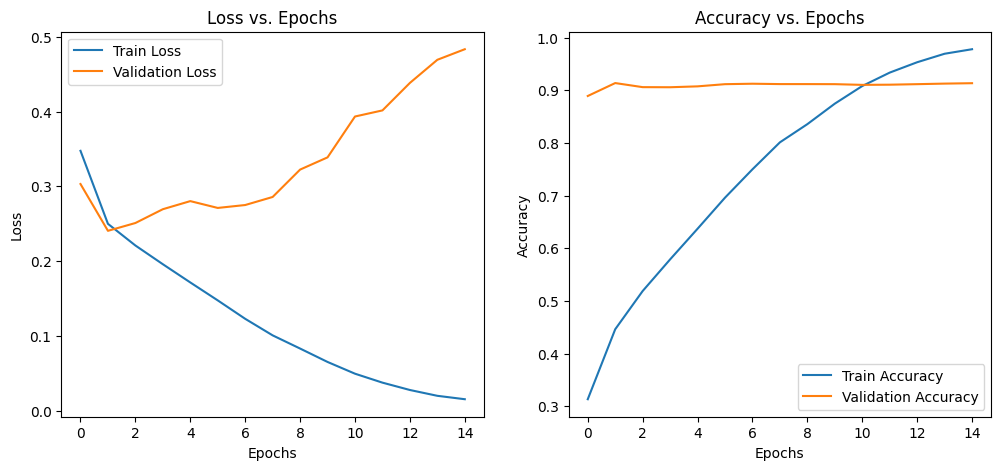

In [9]:
# Plotting
epochs = range(15)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')